In [1]:
import preprocessor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
FIGURE_SIZE = (12, 6)

In [4]:
import os

TEST_IMG_OUTPUT_PATH = "test_images_output"

if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge02.jpg', 'test_images/challenge3.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [5]:
from camera_calibrator import CameraCalibrator, Undistorter



In [6]:
calibrator = CameraCalibrator(9, 6)

calibrator.calibrate()

Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration11.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration20.jpg ...
Calibration successful


In [7]:
mtx, dist = calibrator.get_calibration_data()
print(mtx, dist, calibrator.get_shape())
undistorter = Undistorter(mtx, dist, calibrator.get_shape())

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]] (720, 1280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


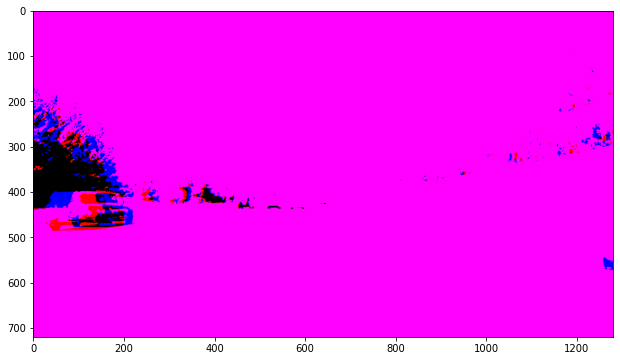

In [8]:
#
#    Calibrator and Undistorter validation
#

img = cv2.imread(test_images[4])
distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
undistorted = undistorter.undistort(distorted)

out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
output = np.zeros(out_shape)
output[:,:,0] = cv2.resize(distorted, (out_shape[1], out_shape[0]))//16
output[:,:,2] = undistorted//16
plt.figure(figsize=FIGURE_SIZE)
plt.imshow(output)

In [9]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a grayscale image """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized

In [10]:
h_center = 1280//2
w_offset = 70
top = 440#460#450
bottom = 660
left = 150
right = 1130
MASK_ROI = np.array([[left, bottom],
                [h_center - w_offset, top],
                [h_center + w_offset, top],
                [right, bottom]]
               , np.int32)
mask = cv2.fillPoly(np.zeros((720,1280), dtype=np.uint8), [MASK_ROI], [255,255,255])

In [11]:
# TODO: warp transform here.

# TODO: encapsulate the default ROI to a class.
''' OLD roi for a cropped undistortion
h_center = 600
h_offset = 20
top = 370
bottom = 620 #630
left = 100
right = 1100'''
h_center = 640
h_offset = 80
top = 470#460#450
bottom = 690
left = 210
right = 1070
CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

class Bird():
    def __init__(self, roi, camera_roi=CAMERA_ROI):
        # ROIs are expected to be np.float32 arrays of shape (4, 2)
        # describing a region starting from the bottom left point clockwise
        self.roi = roi
        self.camera_roi = camera_roi
        self.M = cv2.getPerspectiveTransform(camera_roi, roi)
        self.invM = cv2.getPerspectiveTransform(roi, camera_roi)
    
    def from_above(self, img):
        return cv2.warpPerspective(img, self.M, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)
    
    def to_road(self, img):
        return cv2.warpPerspective(img, self.invM, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)

def to_birdseye(img, roi=CAMERA_ROI):
    """ Expects a trapezoidal ROI to start from the bottom left point """
    """ Expects an undistorted input image """

    M = cv2.getPerspectiveTransform(roi.astype(np.float32), birds_roi)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

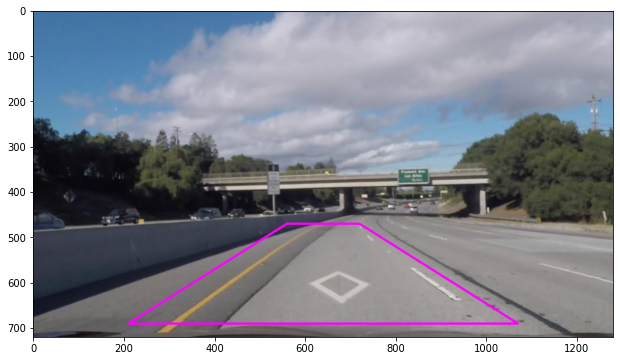

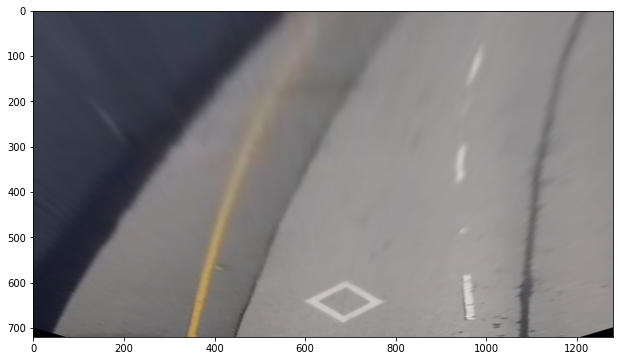

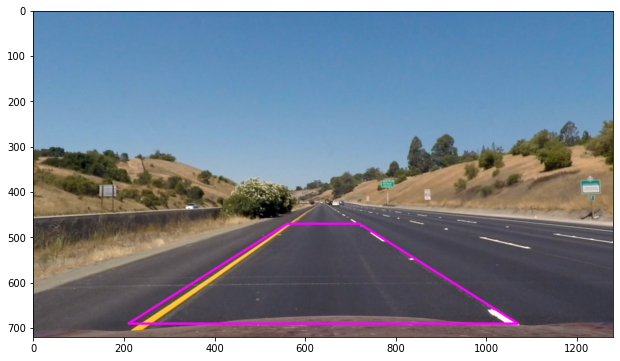

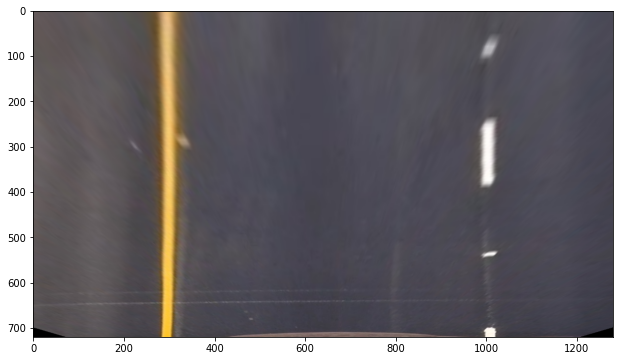

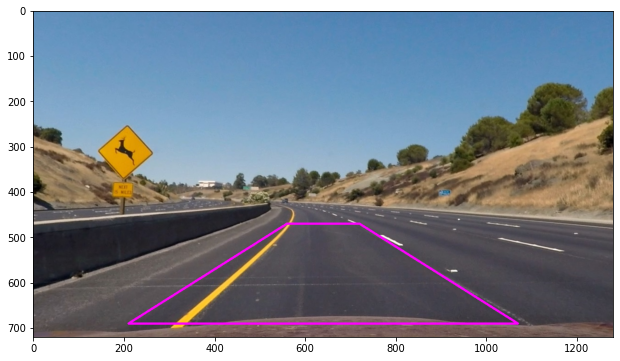

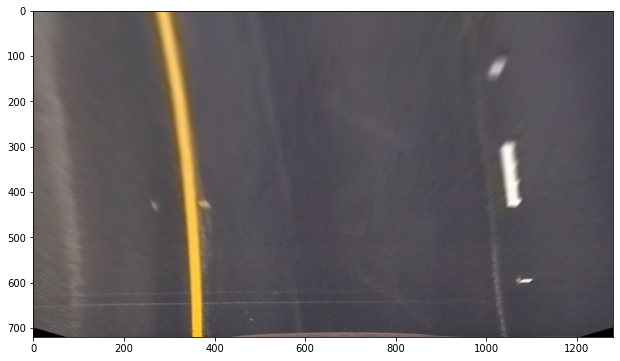

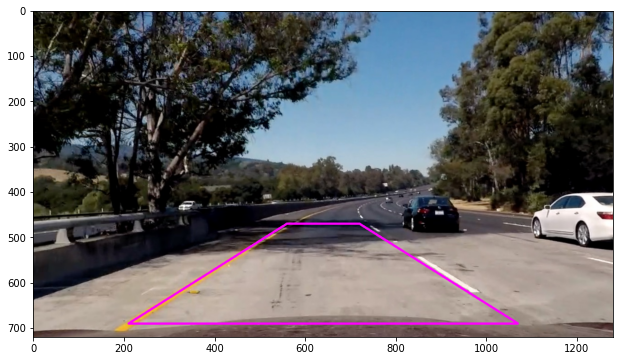

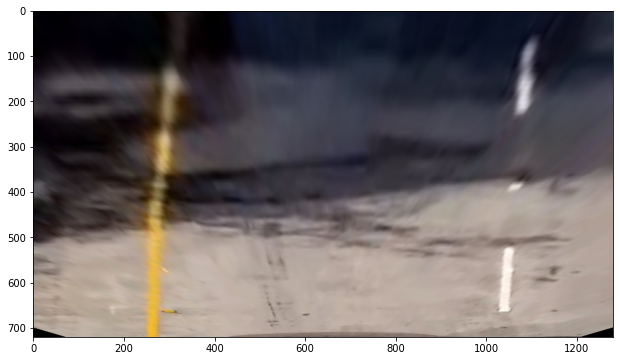

In [12]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in test_images[::3]:
    #break
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    
    fpv = undistorter.undistort(img)
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
        
    plot_bgr(fpv_roi)
    
    birds_eye = bird.from_above(fpv)

    plot_bgr(birds_eye)

In [13]:
def adaptive_contrast(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = hls[:,:,1]
    sat = hls[:,:,2]
    
    top_significant = height//2 + height//10
    
    quarter_lum = lum[top_significant::4, ::4]
    quarter_sat = sat[top_significant::4, ::4]
    
    lum_hist = np.histogram(quarter_lum, 12)
    lum_thr = lum_hist[1][np.argmax(lum_hist[0])]
    
    sat_hist = np.histogram(quarter_sat, 8)
    sat_thr = sat_hist[1][np.argmax(sat_hist[0])]
    
    min_lum = np.maximum(0, quarter_lum.astype(np.int32) - lum_thr)
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2550))

    min_sat = np.maximum(0, quarter_sat.astype(np.int32) - sat_thr)
    sat_part = normalize(np.minimum(np.power(min_sat, 1.5), 600))
    
    mix = np.maximum(sat_part, lum_part)
    mix_hist = np.histogram(mix[::2, ::2],10)
    mix_thr = mix_hist[1][np.argmax(mix_hist[0])]
    mix = np.maximum(0, mix.astype(np.int32) - mix_thr)
    mix = normalize(np.power(mix, 2))
    
    limited_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    output = np.zeros((height, width), dtype=np.uint8)
    output[top_significant:, :] = cv2.resize(limited_mix, (width, height - top_significant))
    return output



In [125]:
def subtract_major_tone(img, downsample_rate=2, accuracy=10):
    """ 
    Finds the nmost popular pixel brightness (major tone) 
    and then subtracts it from the whole image. This way we shift
    brightness curve without adding significant artifacts (as opposed
    to a regular thresholding)
    """
    hist = np.histogram(img[::downsample_rate, ::downsample_rate], accuracy)
    major = hist[1][np.argmax(hist[0])]
    if (major <= 1.0):
        # In some cases, the most popular pixel in an image is black
        # and so there's nothing to subtract; but still we believe
        # the lane markings to be the brightest, and just
        # subtract the _second_ most popular pixel brightness.
        second_max = np.partition(hist[0], -2)[-2]
        second_max_idx = np.where(hist[0] == second_max)[0][0]
        major = hist[1][second_max_idx]

    return np.maximum(0, img.astype(np.int32) - major)

def adaptive_vertical_contrast(img, downsample_rate=2, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Downsampling significantly increases processing speed
    # while introducing only a minor artifacts
    G = img[::downsample_rate, ::downsample_rate, 1]
    R = img[::downsample_rate, ::downsample_rate, 2]

    quarter_lum = hls[::downsample_rate, ::downsample_rate, 1]
    quarter_sat = hls[::downsample_rate, ::downsample_rate, 2]
    
    # Yellow lane marking is the best recognizeabe as a sum of
    # yellow brightness and saturation channel
    yellow = np.uint8((R.astype(np.uint16) + G) // 2)
    filtered_yellow = subtract_major_tone(yellow)

    quarter_sat = np.uint8((quarter_sat.astype(np.uint16) + filtered_yellow) // 2)
    
    #quarter_lum = yellow
    
    min_lum = subtract_major_tone(subtract_major_tone(quarter_lum))
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2550))

    min_sat = subtract_major_tone(subtract_major_tone(quarter_sat))
    sat_part = normalize(np.minimum(np.power(min_sat, 2), 2000))

    mix = np.uint16(np.maximum(sat_part, lum_part))
    mix = normalize(np.power(mix, 2))
    
    clamped_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    output = cv2.resize(clamped_mix, (width, height))
    return output

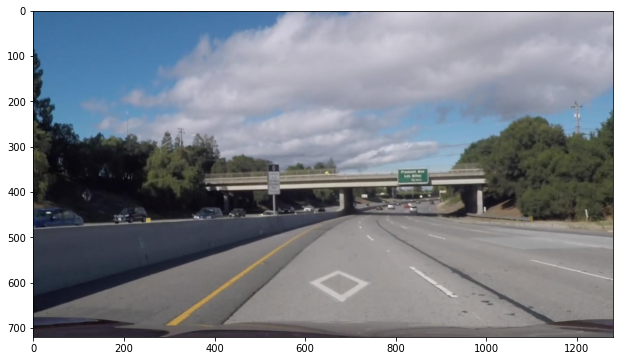

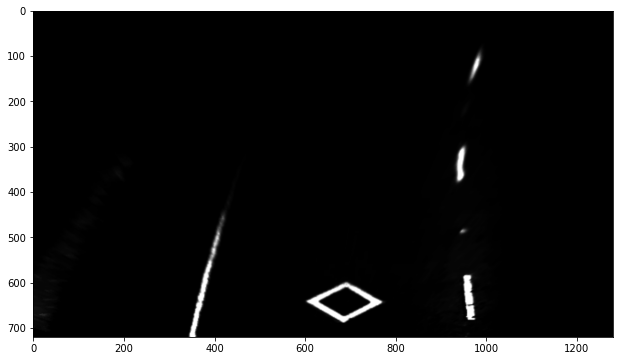

In [126]:
# Validate the HLS pipeline
for test_img in test_images[:1]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    temp = adaptive_vertical_contrast(bird.from_above(undistorter.undistort(img)))
    
    plot_bgr(img)
    plot_gray(temp)

In [127]:
# Good: gray_input, blur_radius=5, sobel_kernel=17 angle_range=(0.7, 1.3), magnitude_range=(75,255)
# TRY; gray_input, blur_radius=3, sobel_kernel=11 angle_range=(0.85, 1.15), magnitude_range=(30,255)
ANGLE_RANGE=(0.6, 1.15)
def amplify_lane_pixels(gray_input, blur_radius=3, sobel_kernel=15
                        , angle_range=ANGLE_RANGE, magnitude_range=(30,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    # blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    direction = np.zeros_like(angles)
    direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;
    magnitude = np.zeros_like(blurred)
    magnitude[(mag_raw > min_magnitude) & (mag_raw < max_magnitude)] = 1
    # plot_gray(magnitude)
    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[((magnitude == 1) & (direction == 1))] = 1
    #combined = magnitude + direction
    # plot_gray(combined)
    dilate_kernel = np.ones((3,3),np.uint8)
    erode_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, dilate_kernel)
    output = combined
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

    
    

In [128]:
def amplify_lane_pixels2(gray_input, blur_radius=5, sobel_kernel=17
                        , angle_range=(0.7, 1.2), magnitude_range=(20,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    #blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    #direction = np.zeros_like(angles)
    #direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[(((mag_raw > min_magnitude) & (mag_raw < max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    output = combined
    #dilate_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_OPEN, dilate_kernel)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

In [129]:
def amplify_vert_lane_pixels(gray_input, blur_radius=5, sobel_kernel=3,
                             angle_range=(-0.5, 0.5), magnitude_range=(20,255),
                             downsample_rate=4, save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    downsample = gray_input[::downsample_rate, ::downsample_rate]

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range

    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(downsample)
    combined[(((mag_raw > min_magnitude) & (mag_raw < max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    output = cv2.resize(normalize(combined), (gray_input.shape[1], gray_input.shape[0]))

    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

In [130]:
def contrast_processing(img):
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    #_, st_1 = cv2.threshold(contrast, 15, 255, cv2.THRESH_BINARY)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    return cv2.cvtColor(st_2, cv2.COLOR_GRAY2RGB)

In [131]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/contrast_harder_challenge_test_video.mp4'
input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/contrast_challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/contrast_test_video.mp4'

# 37-43 subclip of the main one is the worst
clip1 = VideoFileClip(input_video).subclip(3,6)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(contrast_processing)
%time white_clip.write_videofile(test_video_output, audio=False)

t:   3%|▎         | 3/90 [00:00<00:03, 26.80it/s, now=None]

Moviepy - Building video test_video_output/contrast_challenge_test_video.mp4.
Moviepy - Writing video test_video_output/contrast_challenge_test_video.mp4




t:  11%|█         | 53/485 [05:21<00:19, 22.52it/s, now=None][A

Moviepy - Done !
Moviepy - video ready test_video_output/contrast_challenge_test_video.mp4
CPU times: user 10.7 s, sys: 1.34 s, total: 12 s
Wall time: 4.19 s


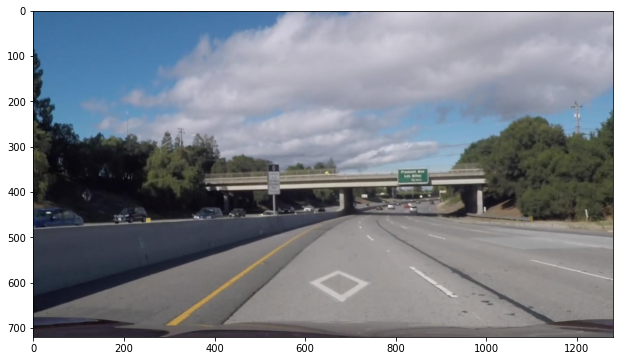

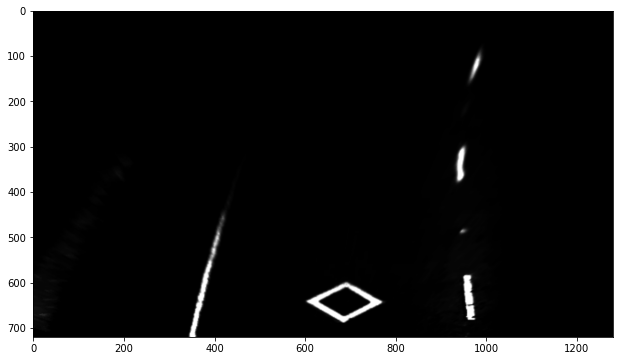

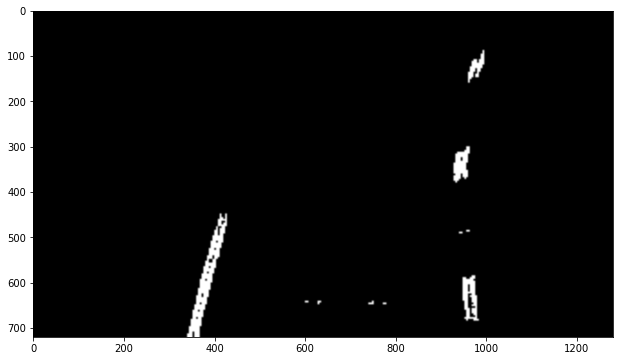

In [132]:
# Validate the HLS pipeline
for test_img in test_images[:1]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    #_, st_1 = cv2.threshold(contrast, 15, 255, cv2.THRESH_BINARY)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    plot_bgr(img)
    plot_gray(contrast)
    #plot_gray(st_1)
    plot_gray(st_2)

In [133]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [134]:
def evaluate_poly2(poly, y):
    ''' Evaluate a 2-grade polynomial '''
    return poly[0]*y*y + poly[1]*y + poly[2]

def get_lane_template_birdeye(shape, lane_width = 60):
    width = shape[1]
    left_line_desired_position = width * 1 // 4
    right_line_desired_position = width * 3 // 4
    salted = np.zeros(shape, dtype=np.uint8)
    salted[:, left_line_desired_position-lane_width:left_line_desired_position+lane_width] = 255
    salted[:, right_line_desired_position-lane_width:right_line_desired_position+lane_width] = 255
    return salted

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high, win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

def take_lane_pixels(binary_warped, lcurve, rcurve, margin=50, downsample_rate=2):
    """
    Expects lcurve and rcurve as array of points.
    Vertical stride along the curve must be the same, and must be
    equal across both curves.
    These points are used as window origins: the point is a [bottom, h_center] of
    a window.
    Curves must be consistent with an image (e.g. of the same height and compatible width)
    Not all of the pixels might be taken into account if the downsample rate is > 1
    (this way further polynome fitting becomes faster)
    """
    assert(len(lcurve) > 2 and len(rcurve) > 2)
    l_v_stride = lcurve[1][1] - lcurve[0][1]
    r_v_stride = rcurve[1][1] - rcurve[0][1]
    assert(l_v_stride == r_v_stride)
    v_stride = l_v_stride
    leftx = []; lefty = []; rightx = []; righty = []
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    for point in lcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            leftx.append(w_x_indices + w_left-1)
            lefty.append(w_y_indices + w_top-1)
        # DEBUG!
        # binary_warped[y:y+v_stride:2, w_left:w_right:2] = 255
    for point in rcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            rightx.append(w_x_indices + w_left-1)
            righty.append(w_y_indices + w_top-1)
        # DEBUG!
        # binary_warped[y:y+v_stride:2, w_left:w_right:2] = 255
    #for arr in [leftx, lefty, rightx, righty]:
    #    if len(arr) > 0:
    #        arr = np.concatenate(arr)
    #leftx = np.concatenate(leftx)
    #lefty = np.concatenate(lefty)
    #rightx = np.concatenate(rightx)
    #righty = np.concatenate(righty)
    leftx = np.concatenate(leftx) if len(leftx) > 0 else np.uint16([])
    lefty = np.concatenate(lefty) if len(lefty) > 0 else np.uint16([])
    rightx = np.concatenate(rightx) if len(rightx) > 0 else np.uint16([])
    righty = np.concatenate(righty) if len(righty) > 0 else np.uint16([])
    return leftx, lefty, rightx, righty
    



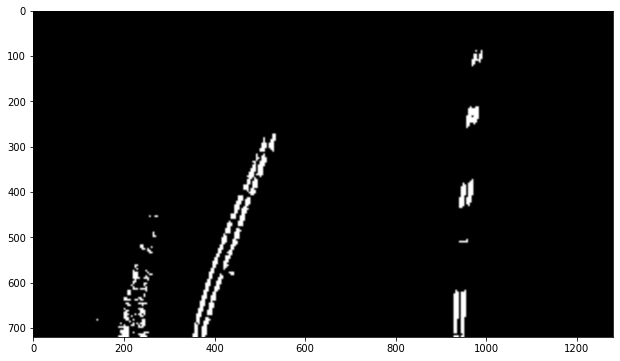

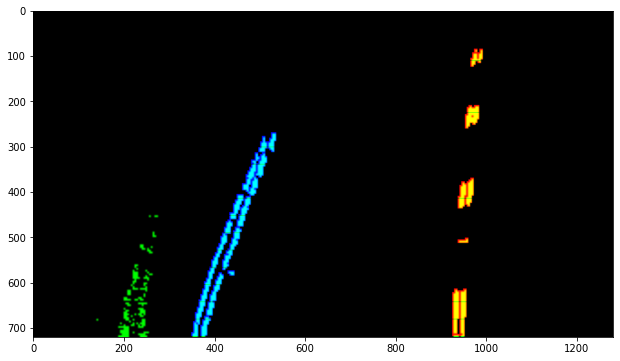

In [135]:

image_tricolor = cv2.imread("bird_eye.png")
test_takepixel_img = cv2.cvtColor(image_tricolor, cv2.COLOR_BGR2GRAY)
test_takepixel_img.shape

lx,ly,rx,ry = find_lane_pixels(test_takepixel_img)
lfit, rfit = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)

lx2,ly2,rx2,ry2 = take_lane_pixels(test_takepixel_img, lcurve, rcurve)

testplot = np.zeros_like(image_tricolor)
testplot[ly2, lx2, 0] = 255
testplot[:,:,1] = test_takepixel_img
testplot[ry2, rx2, 2] = 255


plot_bgr(test_takepixel_img)
plot_bgr(testplot)


In [136]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        salted = get_lane_template_birdeye(binary_warped.shape)
        leftx, lefty, rightx, righty = find_lane_pixels(salted)
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit

def get_plottable_curves(height, left_fit, right_fit, xm_per_pix, ym_per_pix, steps=20):
    ploty = np.linspace(0, height, steps)
    left_curve = np.int32(list(zip(
        evaluate_poly2(left_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    right_curve = np.int32(list(zip(
        evaluate_poly2(right_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    return left_curve, right_curve
    
def plot_lane_curves(lane_img, left_curve, right_curve, thickness=6):
    out_img = cv2.polylines(lane_img, [left_curve], False, [0,255,255], thickness)
    out_img = cv2.polylines(out_img, [right_curve], False, [255,255,0], thickness)
    return out_img

def plot_lane_poly_on(lane_img, left_curve, right_curve, color=[100,200,100]):
    # Right curve's points must go in the opposite order to maintain a
    # polygon's points traversing order.
    points = np.append(left_curve, right_curve[::-1], axis=0)
    cv2.fillPoly(lane_img, [points], color)

In [137]:
class LaneLine():
    def __init__(self, xm_per_pix, ym_per_pix, img_size=(1280, 720), avg_depth=8,
                 max_broken_frames=15, max_valid_diff=2.0, name="Unnamed"):
        self.avg_depth = avg_depth
        # Poly coefficients. averaged during last N calls
        self.avg_fit = None
        self.isValid = False
        # Lane curvature radius in meters
        self.radius_m = 1e3
        # Distance in meters of vehicle center from the line
        # (assuming the car is centered and the lane width is 3.75 meters)
        self.line_base_pos_mm = 3750./2
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        self.img_width, self.img_height = img_size
        self.lane_h_center_mm = (self.img_width // 2) * self.xm_per_pix * 1000.
        self.max_broken_frames = max_broken_frames
        self.broken_frames = 0
        self.name = name
        self.max_valid_diff = max_valid_diff
        self.curve = np.uint8([[0,0]])
    
    def update(self, poly, x_pixels=None, y_pixels=None):
        if x_pixels is not None:
            self.x_pixels = x_pixels
        if y_pixels is not None:
            self.y_pixels = y_pixels
        if self.avg_fit is None:
            self.avg_fit = poly
        else:
            # Improvement of a naive averaging: if the diff is huge,
            # do a more conservative averaging. 
            # TODO: probably, not every member is equally important.
            diff = np.absolute(self.avg_fit - poly)
            weighted_diff = np.absolute(diff[0]) + np.absolute(diff[1]) + np.absolute(diff[2])
            #weighted_diff = np.absolute(diff[0]) + np.absolute(diff[1]) + np.absolute(diff[2])
            #print(" {} weighted_diff : ".format(self.name), weighted_diff)
            if weighted_diff > self.max_valid_diff:
                self.broken_frames += 1
                if self.broken_frames > self.max_broken_frames // 2:
                    self.isValid = False
                if self.broken_frames > self.max_broken_frames:
                    print("ALARM! LANE {} BROKEN!".format(self.name))
                    self.avg_fit = (self.avg_fit * (self.avg_depth - 1) + poly) / self.avg_depth
            else:
                self.avg_fit = (self.avg_fit * (self.avg_depth - 1) + poly) / self.avg_depth
                self.isValid = True
                self.broken_frames = 0
            self.line_base_pos_mm = evaluate_poly2(
                self.avg_fit, self.img_height * self.ym_per_pix)*1000 - self.lane_h_center_mm
            
    def set_curve(self, curve):
        """ Expects a numpy array of points (x,y)"""
        self.curve = curve
        
    def get_curve(self):
        return self.curve
        
    def get_fit(self):
        return self.avg_fit
    
    @staticmethod
    def evaluate_poly2(poly, y):
        # Evaluates a 2-grade polynomial
        return poly[0]*y*y + poly[1]*y + poly[2]
    
    @staticmethod
    def curvature(polynome, ycoord):
        if polynome is None:
            return 0.
        A, B, C = polynome
        numerator = np.power((1 + np.power((2 * A * ycoord + B), 2)), 3/2)
        denominator = 2 * np.abs(A)
        return numerator / denominator
    
    def get_radius(self):
        new_curvature = self.curvature(self.avg_fit, self.img_height * ym_per_pix)
        self.radius_m = (self.radius_m * (self.avg_depth - 1) + new_curvature) / self.avg_depth
        return self.radius_m
    
    def get_horizontal_offset(self):
        return self.line_base_pos_mm
    
    def reset(self):
        self.avg_fit = None
        self.isValid = False
        self.radius_m = 1e3
        self.line_base_pos_mm = 3750./2
        self.allx = None  
        self.ally = None
        self.broken_frames = 0
        self.name = "Unnamed"
        
    def is_valid(self):
        return self.isValid

In [138]:
def plot_circles(img, lcurv, rcurv):
    avg_curv = (lcurv + rcurv) / 2
    r_color = [0,0,255]
    l_color = [255,0,255]
    thickness = 15
    height, width = img.shape[:2]
    h_center = width // 2
    left_avg_center = (int(h_center - avg_curv), height)
    right_avg_center = (int(h_center + avg_curv), height)
    #img, center, radius, color[, thickness
    cv2.circle(img, left_avg_center, int(avg_curv), l_color, thickness)
    cv2.circle(img, right_avg_center, int(avg_curv), r_color, thickness)
    
def plot_curvatures_on(img, lcurvature, rcurvature, color=(255, 255, 255), fontScale = 0.6, thickness = 1):
    height, width = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    origin = (int(width * 0.05), int(height * 0.1)) 

    # Using cv2.putText() method 
    return cv2.putText(img, 
                        "Radius: left {:5.1f} m, right {:5.1f} m, avg lane {:5.1f} m"
                        .format(lcurvature, rcurvature, (lcurvature + rcurvature) / 2), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)

def plot_hcenter_offset_on(img, loffset, roffset, thickness = 1):
    offset = loffset + roffset
    height, width = img.shape[:2]
    green = (0, 255, 0)
    red = (0, 0, 255)
    origin = (int(width * 0.55), int(height * 0.9)) if (offset > 0) else (int(width * 0.35), int(height * 0.9)) 
    color = green if (offset > 0) else red
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 0.6; thickness = 1
    return cv2.putText(img, 
                        "Offset {} mm" .format(int(offset)), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)
    

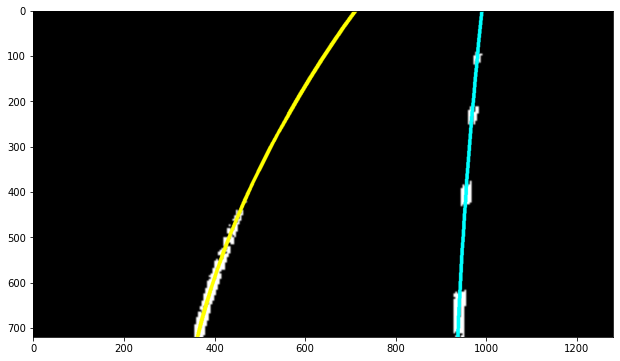

In [139]:
# Validate lane pixel finding via sliding window
for test_img in test_images[2:3]:
    img = cv2.resize(undistorter.undistort(cv2.imread(test_img)), (1280, 720))
    #plot_bgr(plot_roi_on(img, CAMERA_ROI))
    hls = adaptive_vertical_contrast(bird.from_above(img))
    highlight = amplify_vert_lane_pixels(hls)
    birds_eye = highlight
    lx, ly, rx, ry = find_lane_pixels(birds_eye)
    cv2.imwrite("bird_eye.png", birds_eye)
    #print(lx[0])
    lfit, rfit = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)
    lx, ly, rx, ry = take_lane_pixels(birds_eye, lcurve, rcurve)
    #print(lx)
    lfit2, rfit2 = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve2, rcurve2 = get_plottable_curves(img.shape[0], lfit2, rfit2, xm_per_pix, ym_per_pix)

        
    found = plot_lane_curves(cv2.cvtColor(birds_eye, cv2.COLOR_GRAY2BGR), lcurve, rcurve)
    found = plot_lane_curves(found, lcurve2, rcurve2)

    lcurv = LaneLine.curvature(lfit, 720 * ym_per_pix)
    rcurv = LaneLine.curvature(rfit, 720 * ym_per_pix)
   
    #plot_gray(highlight)
    #plot_lane_poly_on(found, lcurve, rcurve)    
    plot_bgr(found)
    

In [150]:
# Note: an Undistorter instance is necessary
# with avg 10 lanes work. L8 + Buf32(_20) is ok too.
# Avg6 + Buf32(_20) works too.
rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Left")

buffer_frame = None
buf_avg = 20

def process_frame(frame):
    global buffer_frame, buf_avg
    global rlane, llane
    
    is_all_ok = (llane.is_valid() and rlane.is_valid())
    downsample_rate = 10
    
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    birds_eye = bird.from_above(undistorter.undistort(frame))
    stage_0_sample = adaptive_vertical_contrast(birds_eye, downsample_rate=downsample_rate)
    stage_1_sample = amplify_vert_lane_pixels(stage_0_sample, downsample_rate=downsample_rate)
    stage_2_sample = normalize(stage_1_sample)
    
    if buffer_frame is None:
        buffer_frame = np.uint32(stage_2_sample)
    else:
        buffer_frame = (buffer_frame * (buf_avg - 1) + stage_2_sample) / buf_avg

    filtered_stage2 = np.zeros_like(stage_2_sample)
    filtered_stage2[buffer_frame > 30] = 1 #20 worked fine! # was 40!
    filtered_stage2 = cv2.morphologyEx(filtered_stage2, cv2.MORPH_OPEN, np.ones((5,5)))

    if is_all_ok:
        # Faster
        downsample_rate = 10
        lx, ly, rx, ry = take_lane_pixels(filtered_stage2,
                                          llane.get_curve(),
                                          rlane.get_curve(),
                                          margin=50)
    else:
        # More robust
        downsample_rate = 2
        lx, ly, rx, ry = find_lane_pixels(filtered_stage2)
    
    # To fit a polynome curve, we need as few points as possible, as it 
    # speeds up computations; but not too few to keep the accuracy.
    fit_downsample = 1 + max(len(lx), len(ly)) // 100
    lfit, rfit = fit_polynomial(filtered_stage2,
                                lx[::fit_downsample],
                                ly[::fit_downsample],
                                rx[::fit_downsample],
                                ry[::fit_downsample],
                                xm_per_pix, ym_per_pix)
    llane.update(lfit); 
    rlane.update(rfit);
    
    lcurve, rcurve = get_plottable_curves(height, llane.get_fit(), rlane.get_fit()
                                          , xm_per_pix, ym_per_pix, steps=15)
    llane.set_curve(lcurve)
    rlane.set_curve(rcurve)
    
    
    stage_3_sample = plot_lane_curves(cv2.cvtColor(normalize(filtered_stage2),
                                                   cv2.COLOR_GRAY2BGR)
                                      , lcurve, rcurve)
    
    tile_01 = cv2.cvtColor(cv2.resize(stage_0_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_10 = cv2.cvtColor(cv2.resize(stage_1_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(stage_3_sample, (width//2, height//2))
        
    road_poly_from_above = np.zeros_like(frame)
    poly_color = [100,200,100] if is_all_ok else [255,0,0]
    plot_lane_poly_on(road_poly_from_above, lcurve, rcurve, color=poly_color)
    lane_poly = bird.to_road(road_poly_from_above)
    tile_00 = cv2.resize(np.maximum(frame, lane_poly), (width//2, height//2))
    
    plot_curvatures_on(tile_00, llane.get_radius(), rlane.get_radius())

    plot_hcenter_offset_on(tile_00, llane.get_horizontal_offset(), rlane.get_horizontal_offset())
    
    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    return output

# Validate lane pixel finding via sliding window
#for test_img in test_images[:1]:
#    img = cv2.resize(cv2.imread(test_img), (1280, 720))
#    plot_bgr(process_frame(img))
#    buffer_frame = None

In [151]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/harder_challenge_test_video.mp4'
input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/test_video.mp4'

# 37-43 subclip of the main one is the worst, challenge problem on 3..6
clip1 = VideoFileClip(input_video)#.subclip(0,6)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)


                                                           
t:  32%|███▏      | 156/485 [00:25<00:18, 18.09it/s, now=None]
                                                           
t:   1%|          | 3/485 [00:00<00:19, 24.45it/s, now=None]e]

Moviepy - Building video test_video_output/challenge_test_video.mp4.
Moviepy - Writing video test_video_output/challenge_test_video.mp4



                                                              
                                                           
t:  32%|███▏      | 156/485 [00:54<00:18, 18.09it/s, now=None]
                                                           
t:  32%|███▏      | 156/485 [00:54<00:18, 18.09it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_video_output/challenge_test_video.mp4
CPU times: user 1min 27s, sys: 11.4 s, total: 1min 39s
Wall time: 28.2 s
